In [45]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [46]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [47]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 80.8 GB  | Proc size: 6.5 GB
GPU RAM Free: 30226MB | Used: 10287MB | Util  25% | Total 40960MB



## Install Huggingface Transformers libraries
---



In [48]:
!pip install transformers
!pip install datasets
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
import tensorflow as tf
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
from tensorflow.keras.utils import plot_model
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

##Load Dataset

In [50]:
dataset = load_dataset('imdb')
train_dataset = dataset['train']
test_dataset = dataset['test']


  0%|          | 0/3 [00:00<?, ?it/s]

##Transformer model and tokenizer

In [51]:
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
DistilBERT = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

In [52]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

def predict_probs(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    inputs = {name: tensor.to(device) for name, tensor in inputs.items()}
    outputs = model(**inputs)
    tensor_logits = outputs[0]
    probas = F.softmax(tensor_logits).detach().cpu().numpy()
    return probas

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

#Training arguments

In [53]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=400,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    )


In [54]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


In [55]:
import time 
start_time = time.time()

In [56]:
trainer = Trainer(
    model=DistilBERT,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.255500,0.226685,0.912880,0.952719,0.868880,0.908870
2,0.221700,0.262161,0.925760,0.948131,0.900800,0.923860
3,0.016500,0.309660,0.932600,0.928046,0.937920,0.932957


TrainOutput(global_step=4689, training_loss=0.17282406368055916, metrics={'train_runtime': 1184.503, 'train_samples_per_second': 63.318, 'train_steps_per_second': 3.959, 'total_flos': 9935054899200000.0, 'train_loss': 0.17282406368055916, 'epoch': 3.0})

In [57]:
#get training time
end_time = time.time()
distilbert_training_time = end_time - start_time
print("DistilBERT training time:", distilbert_training_time)

DistilBERT training time: 1184.6036975383759


In [58]:
D_BERT = torch.save(DistilBERT.state_dict(), "my_distilbert.pt")

In [59]:
#get number of trained parameters
num_parameters = sum(p.numel() for p in DistilBERT.parameters() if p.requires_grad)
print("Number of trainable parameters in DistilBERT model:", num_parameters)

Number of trainable parameters in DistilBERT model: 66955010


##Evaluate model

In [60]:
eval_result = trainer.evaluate()
print(f"Accuracy: {eval_result['eval_accuracy']:.2f}")
print(f"Precision: {eval_result['eval_precision']:.2f}")
print(f"Recall: {eval_result['eval_recall']:.2f}")
print(f"F1-score: {eval_result['eval_f1']:.2f}")


Accuracy: 0.93
Precision: 0.93
Recall: 0.94
F1-score: 0.93


In [143]:
test_dataloader = DataLoader(test_dataset, batch_size=16)  
device = DistilBERT.device

true_labels = []
predicted_probabilities = []

DistilBERT.eval()
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        labels = batch.pop("label")
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = DistilBERT(**batch)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)
        predicted_probabilities.extend(probabilities.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predicted_probabilities = np.array(predicted_probabilities)
true_labels = np.array(true_labels)


Evaluating: 100%|██████████| 1563/1563 [01:32<00:00, 16.98it/s]


In [144]:
predicted_labels = np.argmax(predicted_probabilities, axis=1)


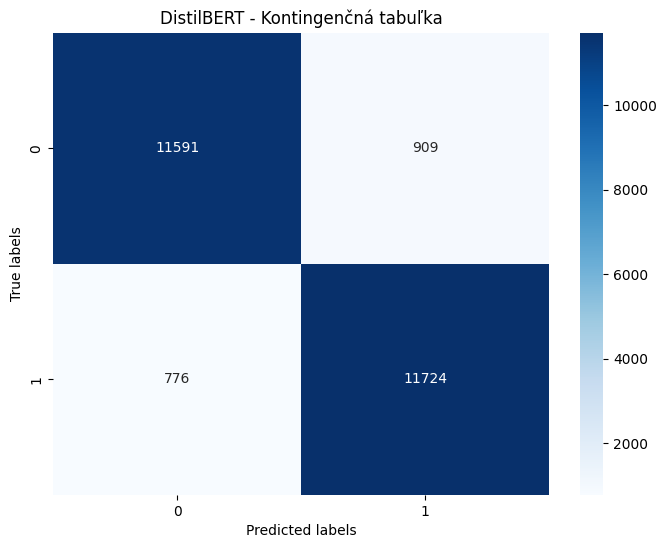

In [145]:
# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
#print("Confusion Matrix:\n", cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('DistilBERT - Kontingenčná tabuľka')
plt.savefig("SA_transformer_CM.png")
plt.show()

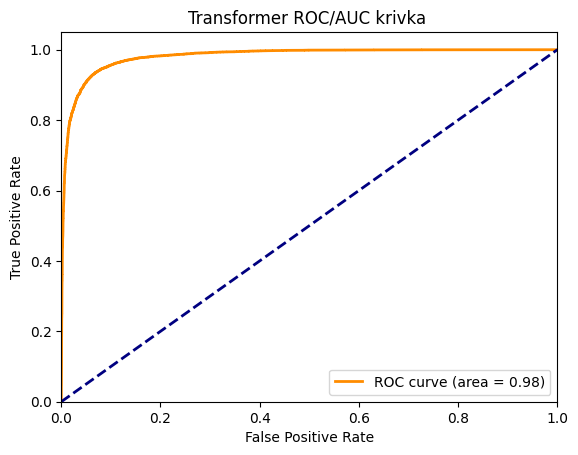

In [146]:
fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transformer ROC/AUC krivka ')
plt.legend(loc="lower right")
plt.savefig('roc_transformer.png')
plt.show()



LSTM comparison

In [65]:
from keras.models import load_model
lstm_model = load_model('lstm.hdf5')

OSError: ignored

In [ ]:
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
predictions_lstm = (lstm_model.predict(X_test) > 0.5).astype('int32')

In [ ]:
#make predictions for lstm
y_pred_lstm = lstm_model.predict(X_test)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute the FPR, TPR, and AUC for the Transformer model
fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities[:, 1])
roc_auc = auc(fpr, tpr)
#ransformer_fpr, transformer_tpr, _ = roc_curve(true_labels, predicted_probabilities[:, 1])
#transformer_auc = roc_auc_score(transformer_fpr, transformer_tpr)

# Compute the FPR, TPR, and AUC for the other model
lstm_fpr, lstm_tpr, _ = roc_curve(y_test, y_pred_lstm)
lstm_auc = roc_auc_score(y_test, y_pred_lstm)

# Plot the ROC curves on the same axis
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Transformer ROC curve (area = %0.2f)' % roc_auc)
plt.plot(lstm_fpr, lstm_tpr, color='green', lw=2, label='Bi-LSTM  ROC curve (area = %0.2f)' % lstm_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.savefig('roc_comparison.png')
plt.show()


## XAI METHODS

##LIME

In [66]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:32'

In [68]:
!pip install git+https://github.com/rentruewang/koila.git@v0.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rentruewang/koila.git (to revision v0.1.1) to /tmp/pip-req-build-92stbhgc
  Running command git clone --filter=blob:none --quiet https://github.com/rentruewang/koila.git /tmp/pip-req-build-92stbhgc
  Running command git checkout -q 42a7cc0dedb1e10b5a62260e369ab2e68c1cab4d
  Resolved https://github.com/rentruewang/koila.git to commit 42a7cc0dedb1e10b5a62260e369ab2e68c1cab4d
  Preparing metadata (setup.py) ... done


In [69]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 81.9 GB  | Proc size: 6.8 GB
GPU RAM Free: 30226MB | Used: 10287MB | Util  25% | Total 40960MB


In [70]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "1"


In [ ]:
#load model 
import torch
from transformers import DistilBertForSequenceClassification

# Replace the file path with the path to your saved DistilBert model
saved_model_path = '/content/my_distilbert.pt'

# Load the saved model
DistilBert = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
DistilBert.load_state_dict(torch.load(saved_model_path))

# Set the model to evaluation mode
DistilBert.eval()


GRID SEARCH FOR SURROGATE MODEL 

In [71]:
def predict_function(text_list):
    predicted_probabilities = []
    for text in text_list:
        test_encodings = tokenizer(text, truncation=True, padding=True, return_tensors='pt')
        with torch.no_grad():
            output = DistilBERT(test_encodings['input_ids'].to(DistilBERT.device), test_encodings['attention_mask'].to(DistilBERT.device))
        predicted_probabilities.append(torch.softmax(output.logits, dim=1).cpu().detach().numpy()[0])
    return np.array(predicted_probabilities)

tokenized_sample = test_dataset['text']


def lime_grid_search(predict_function, tokenized_sample, true_labels, kernel_widths, num_samples_list, accuracy_threshold, sample_size=30):
    optimal_kernel_width = None
    optimal_num_samples = None
    best_avg_accuracy = -1

    random.seed(42)  # Set seed for reproducibility
    sample_indices = random.sample(range(len(tokenized_sample)), sample_size)
    sampled_texts = [tokenized_sample[i] for i in sample_indices]
    sampled_true_labels = [true_labels[i] for i in sample_indices]

    for kernel_width in kernel_widths:
        for num_samples in num_samples_list:
            print(f"Testing kernel_width: {kernel_width}, num_samples: {num_samples}")
            accuracies = []

            for i, text_to_explain in enumerate(sampled_texts):
                if len(text_to_explain.split()) < 2:
                    continue

                true_label = np.array([sampled_true_labels[i]])

                explainer = LimeTextExplainer(kernel_width=kernel_width, class_names=["negative", "positive"], verbose=True, feature_selection='auto')
                explanation = explainer.explain_instance(text_to_explain, predict_function, num_samples=num_samples)
                explanation_list = explanation.as_list()

                sentiment_score = 0
                for _, weight in explanation_list:
                    sentiment_score += weight

                sentiment_threshold = 0
                predicted_label = np.array(["positive" if sentiment_score > sentiment_threshold else "negative"])
                accuracy = accuracy_score(true_label, predicted_label)
                accuracies.append(accuracy)

            avg_accuracy = np.mean(accuracies)
            print(f"Average accuracy for kernel_width {kernel_width}, num_samples {num_samples}: {avg_accuracy}")

            if avg_accuracy > best_avg_accuracy:
                best_avg_accuracy = avg_accuracy
                optimal_kernel_width = kernel_width
                optimal_num_samples = num_samples

                if best_avg_accuracy >= accuracy_threshold:
                    break
        if best_avg_accuracy >= accuracy_threshold:
            break

    return optimal_kernel_width, optimal_num_samples, best_avg_accuracy

# Define the range of kernel widths and num_samples you want to search
kernel_widths = np.arange(1, 3, 0.5)
num_samples_list = list(range(100, 3000, 100))
accuracy_threshold = 0.9  # Define your desired threshold for average accuracy
optimal_kernel_width, optimal_num_samples, best_avg_accuracy = lime_grid_search(predict_function, tokenized_sample, true_labels, kernel_widths, num_samples_list, accuracy_threshold)

print(f"Optimal kernel width: {optimal_kernel_width}")
print(f"Optimal num_samples: {optimal_num_samples}")
print(f"Best average accuracy: {best_avg_accuracy}")

Testing kernel_width: 1.0, num_samples: 100
Intercept 0.9888899347861979
Prediction_local [0.9942374]
Right: 0.99611354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.10927081617653811
Prediction_local [0.04877355]
Right: 0.043278545


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007291541009586662
Prediction_local [0.00072725]
Right: 0.0007274526


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989714787816651
Prediction_local [0.99892353]
Right: 0.998904


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007144852495701485
Prediction_local [0.00073169]
Right: 0.0007344822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008278906552214133
Prediction_local [0.0008345]
Right: 0.00083768636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9935116548969191
Prediction_local [0.99593239]
Right: 0.9964223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9436710783896327
Prediction_local [0.96712843]
Right: 0.97473156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992626564352043
Prediction_local [0.99926318]
Right: 0.9992624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008383788370839263
Prediction_local [0.00079345]
Right: 0.0007707312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9993088909944177
Prediction_local [0.9993142]
Right: 0.9993167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9991994243374062
Prediction_local [0.99921954]
Right: 0.99922764


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989695040965355
Prediction_local [0.99895899]
Right: 0.9989594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.007589679953601432
Prediction_local [0.00231884]
Right: 0.0009115656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990566164415496
Prediction_local [0.99904769]
Right: 0.9990361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9270009526466474
Prediction_local [0.97811228]
Right: 0.96477824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0010868154697153255
Prediction_local [0.00097912]
Right: 0.00096808706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009415645603556693
Prediction_local [0.00085599]
Right: 0.00084570306


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.00075672558848173
Prediction_local [0.00072051]
Right: 0.00071742246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.006396964094767024
Prediction_local [0.00428449]
Right: 0.0035938758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008681593253366844
Prediction_local [0.0008373]
Right: 0.0008371007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.2916041242751837
Prediction_local [0.90595848]
Right: 0.91357636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9977464627708315
Prediction_local [0.99764709]
Right: 0.99688977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007841742179445083
Prediction_local [0.00074491]
Right: 0.00073403446


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.11836096464349263
Prediction_local [0.00569674]
Right: 0.0021163863


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007120376544934207
Prediction_local [0.00071608]
Right: 0.0007177514


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989249112269463
Prediction_local [0.99900564]
Right: 0.9990294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9982019020260479
Prediction_local [0.99843004]
Right: 0.9984132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989325042471411
Prediction_local [0.99901325]
Right: 0.9990656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992222670832874
Prediction_local [0.99923263]
Right: 0.99923337
Average accuracy for kernel_width 1.0, num_samples 100: 0.0
Testing kernel_width: 1.0, num_samples: 200


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.6180896378987947
Prediction_local [0.94715684]
Right: 0.99611354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.20611148719014385
Prediction_local [0.06575742]
Right: 0.043278545


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007446222519573466
Prediction_local [0.00072866]
Right: 0.0007274526


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.99889033459302
Prediction_local [0.99890181]
Right: 0.998904


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007366262378895051
Prediction_local [0.00073457]
Right: 0.0007344822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.001034559364731452
Prediction_local [0.00087314]
Right: 0.00083768636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9559494238845916
Prediction_local [0.99482877]
Right: 0.9964223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.48208968512556766
Prediction_local [0.92738648]
Right: 0.97473156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992726873658715
Prediction_local [0.99926387]
Right: 0.9992624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008277746653799354
Prediction_local [0.00076856]
Right: 0.0007707312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9993065942126302
Prediction_local [0.99931381]
Right: 0.9993167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992062080377498
Prediction_local [0.99922172]
Right: 0.99922764


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989531560691465
Prediction_local [0.99895038]
Right: 0.9989594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008896004778396975
Prediction_local [0.00089991]
Right: 0.0009115656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990387462308321
Prediction_local [0.99903982]
Right: 0.9990361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.5685038587452287
Prediction_local [0.95438801]
Right: 0.96477824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0012861836822118727
Prediction_local [0.00098721]
Right: 0.00096808706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008663233827304742
Prediction_local [0.00085571]
Right: 0.00084570306


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.000733857292612615
Prediction_local [0.00072036]
Right: 0.00071742246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.017993006225542688
Prediction_local [0.00575368]
Right: 0.0035938758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008239563441316951
Prediction_local [0.00084109]
Right: 0.0008371007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 1.03387274974069
Prediction_local [0.96053542]
Right: 0.91357636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9895495511892181
Prediction_local [0.99734838]
Right: 0.99688977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008247024138056747
Prediction_local [0.00074909]
Right: 0.00073403446


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0027526387353863924
Prediction_local [0.00227686]
Right: 0.0021163863


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0006997337005656046
Prediction_local [0.00071628]
Right: 0.0007177514


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990284489452299
Prediction_local [0.99901904]
Right: 0.9990294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.4421310419027601
Prediction_local [0.98733913]
Right: 0.9984132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9979046145393207
Prediction_local [0.99855327]
Right: 0.9990656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.999147074089104
Prediction_local [0.99922264]
Right: 0.99923337
Average accuracy for kernel_width 1.0, num_samples 200: 0.0
Testing kernel_width: 1.0, num_samples: 300


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.7341200133244142
Prediction_local [0.97231331]
Right: 0.99611354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9031683892674269
Prediction_local [0.15914354]
Right: 0.043278545


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007332477795963406
Prediction_local [0.00072762]
Right: 0.0007274526


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9988893845421173
Prediction_local [0.99891343]
Right: 0.998904


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007246635188728972
Prediction_local [0.00072829]
Right: 0.0007344822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0010552711237974684
Prediction_local [0.00086565]
Right: 0.00083768636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.6870817981796435
Prediction_local [0.97893536]
Right: 0.9964223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.6330832891787814
Prediction_local [0.92070891]
Right: 0.97473156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992719711889413
Prediction_local [0.99926377]
Right: 0.9992624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008675650434984236
Prediction_local [0.00078148]
Right: 0.0007707312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9993029235835065
Prediction_local [0.99931253]
Right: 0.9993167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9991987001159154
Prediction_local [0.99922027]
Right: 0.99922764


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989180461214082
Prediction_local [0.9989546]
Right: 0.9989594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0018893706835728112
Prediction_local [0.00092633]
Right: 0.0009115656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990547823378914
Prediction_local [0.99903579]
Right: 0.9990361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.31518312474135046
Prediction_local [0.9506322]
Right: 0.96477824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.001312640572973652
Prediction_local [0.00100316]
Right: 0.00096808706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009312156568299044
Prediction_local [0.00085213]
Right: 0.00084570306


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007778314023134999
Prediction_local [0.00071419]
Right: 0.00071742246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.006912577986335959
Prediction_local [0.00384562]
Right: 0.0035938758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008540636164697936
Prediction_local [0.00084295]
Right: 0.0008371007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.1667666438806723
Prediction_local [0.93133694]
Right: 0.91357636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9961709159221395
Prediction_local [0.99734556]
Right: 0.99688977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007967078974084621
Prediction_local [0.00074524]
Right: 0.00073403446


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.012276498495520035
Prediction_local [0.00225345]
Right: 0.0021163863


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007431255912032883
Prediction_local [0.00071913]
Right: 0.0007177514


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990499342934711
Prediction_local [0.99902706]
Right: 0.9990294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.6241864248034061
Prediction_local [0.98169236]
Right: 0.9984132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989216355396163
Prediction_local [0.99903214]
Right: 0.9990656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.999224394444261
Prediction_local [0.99922679]
Right: 0.99923337
Average accuracy for kernel_width 1.0, num_samples 300: 0.0
Testing kernel_width: 1.0, num_samples: 400


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9819732930492348
Prediction_local [0.99410826]
Right: 0.99611354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.668756824664829
Prediction_local [0.08309429]
Right: 0.043278545


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007350007897829204
Prediction_local [0.00072726]
Right: 0.0007274526


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989369352102111
Prediction_local [0.99890492]
Right: 0.998904


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0006885059464237698
Prediction_local [0.00072472]
Right: 0.0007344822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008866940265580383
Prediction_local [0.00085117]
Right: 0.00083768636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.6009457894177204
Prediction_local [0.97898955]
Right: 0.9964223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.37035881340239085
Prediction_local [0.91641309]
Right: 0.97473156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992659973846426
Prediction_local [0.99926236]
Right: 0.9992624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007985791954961842
Prediction_local [0.00077367]
Right: 0.0007707312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.999312341814895
Prediction_local [0.99931557]
Right: 0.9993167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9991466599472074
Prediction_local [0.99921665]
Right: 0.99922764


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9988414150930837
Prediction_local [0.99894112]
Right: 0.9989594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.020065897371504902
Prediction_local [0.00166441]
Right: 0.0009115656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990330271138974
Prediction_local [0.99904049]
Right: 0.9990361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.13766987899285954
Prediction_local [0.89314056]
Right: 0.96477824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0010793950865056786
Prediction_local [0.0009928]
Right: 0.00096808706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009439671346771582
Prediction_local [0.0008553]
Right: 0.00084570306


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007775874341482108
Prediction_local [0.00072117]
Right: 0.00071742246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.007905665006377526
Prediction_local [0.00398433]
Right: 0.0035938758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008868496276441679
Prediction_local [0.00084751]
Right: 0.0008371007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.3945660267001312
Prediction_local [0.97310427]
Right: 0.91357636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9140899308361785
Prediction_local [0.99719513]
Right: 0.99688977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008166980496721874
Prediction_local [0.00075606]
Right: 0.00073403446


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.11625415846705207
Prediction_local [0.00834761]
Right: 0.0021163863


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007148163586407091
Prediction_local [0.00071682]
Right: 0.0007177514


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990782461563033
Prediction_local [0.9990269]
Right: 0.9990294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9933510697051561
Prediction_local [0.99788953]
Right: 0.9984132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9988143240297351
Prediction_local [0.99900168]
Right: 0.9990656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992041850667801
Prediction_local [0.99922967]
Right: 0.99923337
Average accuracy for kernel_width 1.0, num_samples 400: 0.0
Testing kernel_width: 1.0, num_samples: 500


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.7938123721177103
Prediction_local [0.97398835]
Right: 0.99611354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.34095287151056186
Prediction_local [0.07830797]
Right: 0.043278545


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007297553310310789
Prediction_local [0.00072566]
Right: 0.0007274526


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9985528316465323
Prediction_local [0.99887111]
Right: 0.998904


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007563594708723955
Prediction_local [0.00072979]
Right: 0.0007344822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0022891694067106983
Prediction_local [0.00092421]
Right: 0.00083768636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.8753345591448507
Prediction_local [0.99274787]
Right: 0.9964223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.07657594011393609
Prediction_local [0.89445296]
Right: 0.97473156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992555355699624
Prediction_local [0.99926178]
Right: 0.9992624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.000837370653579973
Prediction_local [0.0007745]
Right: 0.0007707312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.999289012835093
Prediction_local [0.99931259]
Right: 0.9993167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9991670726929037
Prediction_local [0.99921805]
Right: 0.99922764


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9988886154803249
Prediction_local [0.99894641]
Right: 0.9989594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.00761833632910678
Prediction_local [0.00125514]
Right: 0.0009115656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989783072693741
Prediction_local [0.99902844]
Right: 0.9990361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.042356696513989545
Prediction_local [0.94024076]
Right: 0.96477824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0014021588666758209
Prediction_local [0.00100233]
Right: 0.00096808706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0010488524526588742
Prediction_local [0.00086035]
Right: 0.00084570306


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008616842731616948
Prediction_local [0.00072199]
Right: 0.00071742246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.013339036024219342
Prediction_local [0.00427829]
Right: 0.0035938758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008941242981784551
Prediction_local [0.00084499]
Right: 0.0008371007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.09529277750473641
Prediction_local [0.91288296]
Right: 0.91357636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9991823214688818
Prediction_local [0.99742633]
Right: 0.99688977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.000807019270191996
Prediction_local [0.00074303]
Right: 0.00073403446


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.60990282351491
Prediction_local [0.00941526]
Right: 0.0021163863


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007181233695066129
Prediction_local [0.00071504]
Right: 0.0007177514


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990215179827516
Prediction_local [0.99902452]
Right: 0.9990294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.8164797662794773
Prediction_local [0.99341712]
Right: 0.9984132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9985961223258786
Prediction_local [0.99897226]
Right: 0.9990656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9991915383855311
Prediction_local [0.99923135]
Right: 0.99923337
Average accuracy for kernel_width 1.0, num_samples 500: 0.0
Testing kernel_width: 1.0, num_samples: 600


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.8297047145773323
Prediction_local [0.98512203]
Right: 0.99611354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.8339808759828946
Prediction_local [0.10730078]
Right: 0.043278545


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007699187635020663
Prediction_local [0.00072795]
Right: 0.0007274526


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989854110155786
Prediction_local [0.99891415]
Right: 0.998904


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007513200637358225
Prediction_local [0.00072925]
Right: 0.0007344822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.00089238755627157
Prediction_local [0.00085606]
Right: 0.00083768636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.48466805754030146
Prediction_local [0.97777233]
Right: 0.9964223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.03157489531780089
Prediction_local [0.91356158]
Right: 0.97473156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992750712072843
Prediction_local [0.99926294]
Right: 0.9992624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008550265562825398
Prediction_local [0.00077925]
Right: 0.0007707312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992755487983782
Prediction_local [0.99931355]
Right: 0.9993167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9991844590758946
Prediction_local [0.99922043]
Right: 0.99922764


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9988002748188728
Prediction_local [0.99894406]
Right: 0.9989594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.008168660218206255
Prediction_local [0.00101185]
Right: 0.0009115656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.998950236635071
Prediction_local [0.99903593]
Right: 0.9990361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.2932229693904711
Prediction_local [0.95856107]
Right: 0.96477824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.001078787226310528
Prediction_local [0.00100234]
Right: 0.00096808706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009538925190172547
Prediction_local [0.00086214]
Right: 0.00084570306


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007600482825501758
Prediction_local [0.00072077]
Right: 0.00071742246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.03624752216345282
Prediction_local [0.00548534]
Right: 0.0035938758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009275100485435972
Prediction_local [0.00084723]
Right: 0.0008371007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.19850544763251143
Prediction_local [0.92418013]
Right: 0.91357636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9936805942906308
Prediction_local [0.99764201]
Right: 0.99688977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0010229475900394639
Prediction_local [0.0007476]
Right: 0.00073403446


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.06688962949469081
Prediction_local [0.00250358]
Right: 0.0021163863


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007312492844202358
Prediction_local [0.00071617]
Right: 0.0007177514


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989613731770979
Prediction_local [0.99902741]
Right: 0.9990294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9922683187271742
Prediction_local [0.99833456]
Right: 0.9984132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9972779266870021
Prediction_local [0.99867846]
Right: 0.9990656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.998978112178034
Prediction_local [0.99922478]
Right: 0.99923337
Average accuracy for kernel_width 1.0, num_samples 600: 0.0
Testing kernel_width: 1.0, num_samples: 700


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.8617740394106389
Prediction_local [0.98584448]
Right: 0.99611354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.766137319904486
Prediction_local [0.06361836]
Right: 0.043278545


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007654015827624732
Prediction_local [0.00072802]
Right: 0.0007274526


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9988674473756542
Prediction_local [0.99891004]
Right: 0.998904


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007265736749812224
Prediction_local [0.00072934]
Right: 0.0007344822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0016121349064221603
Prediction_local [0.0008776]
Right: 0.00083768636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.40221876631090525
Prediction_local [0.97576454]
Right: 0.9964223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.2766307107314465
Prediction_local [0.88632884]
Right: 0.97473156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992678182045664
Prediction_local [0.99926396]
Right: 0.9992624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008917169752765822
Prediction_local [0.00077571]
Right: 0.0007707312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992931130389879
Prediction_local [0.99931485]
Right: 0.9993167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9991465685106142
Prediction_local [0.99921778]
Right: 0.99922764


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9988574723122693
Prediction_local [0.99894928]
Right: 0.9989594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0016466060337790244
Prediction_local [0.00093855]
Right: 0.0009115656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989857996959233
Prediction_local [0.99903043]
Right: 0.9990361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.07036638703346176
Prediction_local [0.95868522]
Right: 0.96477824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0012335887218007284
Prediction_local [0.00099657]
Right: 0.00096808706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008738103441533492
Prediction_local [0.00085511]
Right: 0.00084570306


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007976704714298407
Prediction_local [0.00071907]
Right: 0.00071742246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.012603429927623297
Prediction_local [0.00670229]
Right: 0.0035938758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009428693114496083
Prediction_local [0.00084709]
Right: 0.0008371007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.24650498720316816
Prediction_local [0.89884173]
Right: 0.91357636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9946561061059283
Prediction_local [0.99751147]
Right: 0.99688977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009943095085146456
Prediction_local [0.00074849]
Right: 0.00073403446


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.5340308335675831
Prediction_local [0.01213791]
Right: 0.0021163863


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007001258638740366
Prediction_local [0.00071569]
Right: 0.0007177514


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990115152471531
Prediction_local [0.99901549]
Right: 0.9990294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9894464285319294
Prediction_local [0.9980355]
Right: 0.9984132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9984517755097058
Prediction_local [0.99894148]
Right: 0.9990656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990185241724148
Prediction_local [0.99922655]
Right: 0.99923337
Average accuracy for kernel_width 1.0, num_samples 700: 0.0
Testing kernel_width: 1.0, num_samples: 800


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.8105390069067147
Prediction_local [0.98558718]
Right: 0.99611354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.39299326345172814
Prediction_local [0.0689627]
Right: 0.043278545


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007569823544300194
Prediction_local [0.00072733]
Right: 0.0007274526


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9985055986365462
Prediction_local [0.99891351]
Right: 0.998904


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.000687542652403374
Prediction_local [0.00072923]
Right: 0.0007344822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009012324687893759
Prediction_local [0.00085844]
Right: 0.00083768636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.1578526513206573
Prediction_local [0.95923148]
Right: 0.9964223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.09956703323584037
Prediction_local [0.92052213]
Right: 0.97473156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992868928077553
Prediction_local [0.99926457]
Right: 0.9992624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008432469771190939
Prediction_local [0.00076881]
Right: 0.0007707312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992974746206548
Prediction_local [0.99931438]
Right: 0.9993167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.999134859802511
Prediction_local [0.99921882]
Right: 0.99922764


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9988259642409484
Prediction_local [0.99894941]
Right: 0.9989594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0012059109667869948
Prediction_local [0.00093127]
Right: 0.0009115656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990532036589986
Prediction_local [0.9990333]
Right: 0.9990361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0754313039381459
Prediction_local [0.94208664]
Right: 0.96477824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.001421183676314283
Prediction_local [0.00099939]
Right: 0.00096808706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009836037344695657
Prediction_local [0.00084934]
Right: 0.00084570306


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.000837035713470294
Prediction_local [0.00072005]
Right: 0.00071742246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.01755233208906795
Prediction_local [0.00655064]
Right: 0.0035938758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009492265461128633
Prediction_local [0.00084117]
Right: 0.0008371007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.5573422328489726
Prediction_local [0.93436798]
Right: 0.91357636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.996190686382566
Prediction_local [0.99772322]
Right: 0.99688977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0010176111226130886
Prediction_local [0.00075239]
Right: 0.00073403446


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.07953678549369275
Prediction_local [0.00349626]
Right: 0.0021163863


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007070199995942269
Prediction_local [0.00071401]
Right: 0.0007177514


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.999026502262709
Prediction_local [0.9990135]
Right: 0.9990294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.09722701949914236
Prediction_local [0.99333269]
Right: 0.9984132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.99891861029356
Prediction_local [0.99902532]
Right: 0.9990656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9991550093368212
Prediction_local [0.99923019]
Right: 0.99923337
Average accuracy for kernel_width 1.0, num_samples 800: 0.0
Testing kernel_width: 1.0, num_samples: 900


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9297524652311422
Prediction_local [0.99167546]
Right: 0.99611354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9329915247787728
Prediction_local [0.08785229]
Right: 0.043278545


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007805407476333297
Prediction_local [0.00073151]
Right: 0.0007274526


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9984849128073815
Prediction_local [0.99891291]
Right: 0.998904


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007375471311346126
Prediction_local [0.00072927]
Right: 0.0007344822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0029142966144200134
Prediction_local [0.00092254]
Right: 0.00083768636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.23591126251114636
Prediction_local [0.96367026]
Right: 0.9964223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.060542333616024346
Prediction_local [0.89673485]
Right: 0.97473156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992603802938927
Prediction_local [0.9992613]
Right: 0.9992624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009651775892314284
Prediction_local [0.00077922]
Right: 0.0007707312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.999281843158345
Prediction_local [0.99931513]
Right: 0.9993167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9991545942603195
Prediction_local [0.99921736]
Right: 0.99922764


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990031227290584
Prediction_local [0.99895196]
Right: 0.9989594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.07590923156349197
Prediction_local [0.0033534]
Right: 0.0009115656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990053009785745
Prediction_local [0.99903056]
Right: 0.9990361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.7420618934919132
Prediction_local [0.97375695]
Right: 0.96477824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.001301852744042189
Prediction_local [0.00100341]
Right: 0.00096808706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.000917717677877069
Prediction_local [0.00085392]
Right: 0.00084570306


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008443230409196953
Prediction_local [0.00072195]
Right: 0.00071742246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.07837316321088764
Prediction_local [0.00609863]
Right: 0.0035938758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009332422624889775
Prediction_local [0.00084531]
Right: 0.0008371007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.8642748093335739
Prediction_local [0.89987281]
Right: 0.91357636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9986980075794937
Prediction_local [0.99778038]
Right: 0.99688977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0012659385934426712
Prediction_local [0.00076227]
Right: 0.00073403446


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.07948938854592238
Prediction_local [0.00384363]
Right: 0.0021163863


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007182280506780782
Prediction_local [0.00071685]
Right: 0.0007177514


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9988507533194028
Prediction_local [0.99902514]
Right: 0.9990294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.3815905245655191
Prediction_local [0.98179716]
Right: 0.9984132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.99715967367906
Prediction_local [0.99876645]
Right: 0.9990656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9991679074382328
Prediction_local [0.99922768]
Right: 0.99923337
Average accuracy for kernel_width 1.0, num_samples 900: 0.0
Testing kernel_width: 1.0, num_samples: 1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.8216205107343519
Prediction_local [0.99112986]
Right: 0.99611354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.654179775891406
Prediction_local [0.05979394]
Right: 0.043278545


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008080817664187206
Prediction_local [0.00072711]
Right: 0.0007274526


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9987938842968681
Prediction_local [0.99892001]
Right: 0.998904


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007134561827502541
Prediction_local [0.00072705]
Right: 0.0007344822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0034303486611174934
Prediction_local [0.00096196]
Right: 0.00083768636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.45019740976904365
Prediction_local [0.97817432]
Right: 0.9964223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.03389132688748342
Prediction_local [0.90539543]
Right: 0.97473156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992710309753585
Prediction_local [0.9992631]
Right: 0.9992624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008867855124747226
Prediction_local [0.00077837]
Right: 0.0007707312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992957942089621
Prediction_local [0.99931443]
Right: 0.9993167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9991049615836959
Prediction_local [0.99922018]
Right: 0.99922764


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989514243206177
Prediction_local [0.99896273]
Right: 0.9989594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.01635342190443811
Prediction_local [0.00112163]
Right: 0.0009115656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989154432021995
Prediction_local [0.99903175]
Right: 0.9990361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.12500151624117428
Prediction_local [0.93582646]
Right: 0.96477824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.001184742910569961
Prediction_local [0.00099101]
Right: 0.00096808706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.001106357709835373
Prediction_local [0.00085624]
Right: 0.00084570306


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007703535349729319
Prediction_local [0.00071842]
Right: 0.00071742246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.06571129465432843
Prediction_local [0.00498371]
Right: 0.0035938758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008745596390332845
Prediction_local [0.00084631]
Right: 0.0008371007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.44296821102173256
Prediction_local [0.93965321]
Right: 0.91357636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9731712991280798
Prediction_local [0.99739579]
Right: 0.99688977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0010080334317479566
Prediction_local [0.00075238]
Right: 0.00073403446


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.22734738056240367
Prediction_local [0.00403995]
Right: 0.0021163863


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.000699780790619211
Prediction_local [0.00071335]
Right: 0.0007177514


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990311589993466
Prediction_local [0.99902681]
Right: 0.9990294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.15629792503171092
Prediction_local [0.9963439]
Right: 0.9984132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9988921248630576
Prediction_local [0.99902632]
Right: 0.9990656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9985754086732326
Prediction_local [0.99922156]
Right: 0.99923337
Average accuracy for kernel_width 1.0, num_samples 1000: 0.0
Testing kernel_width: 1.0, num_samples: 1100


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.8840520206783589
Prediction_local [0.99106593]
Right: 0.99611354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.6369368843636279
Prediction_local [0.07179562]
Right: 0.043278545


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.000858916638685185
Prediction_local [0.00072848]
Right: 0.0007274526


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9987213759340936
Prediction_local [0.99892048]
Right: 0.998904


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007300790746983353
Prediction_local [0.00072679]
Right: 0.0007344822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.002077759111426309
Prediction_local [0.00092057]
Right: 0.00083768636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.5101874477570215
Prediction_local [0.96241916]
Right: 0.9964223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.06416154428669951
Prediction_local [0.90830653]
Right: 0.97473156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992689620943955
Prediction_local [0.99926204]
Right: 0.9992624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.00099935770763698
Prediction_local [0.00078326]
Right: 0.0007707312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992830376494263
Prediction_local [0.99931553]
Right: 0.9993167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.999144720067403
Prediction_local [0.9992191]
Right: 0.99922764


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989124385089699
Prediction_local [0.99895426]
Right: 0.9989594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.29763102249434276
Prediction_local [0.00453261]
Right: 0.0009115656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989340853231097
Prediction_local [0.9990389]
Right: 0.9990361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.3652183859769478
Prediction_local [0.94003048]
Right: 0.96477824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0014966841194909543
Prediction_local [0.0010126]
Right: 0.00096808706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009888161229888758
Prediction_local [0.00086283]
Right: 0.00084570306


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009181636405971689
Prediction_local [0.00072538]
Right: 0.00071742246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.02600205674882124
Prediction_local [0.00459476]
Right: 0.0035938758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008869445507236314
Prediction_local [0.00084805]
Right: 0.0008371007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.26692191933850573
Prediction_local [0.93876553]
Right: 0.91357636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9847212426153326
Prediction_local [0.99730234]
Right: 0.99688977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009294966957681787
Prediction_local [0.00074856]
Right: 0.00073403446


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.21926340115984308
Prediction_local [0.00400221]
Right: 0.0021163863


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007094868206004532
Prediction_local [0.00071669]
Right: 0.0007177514


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989654322579209
Prediction_local [0.99901445]
Right: 0.9990294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.20740354309254794
Prediction_local [0.99253467]
Right: 0.9984132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9888174351887073
Prediction_local [0.99860653]
Right: 0.9990656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9991275404671118
Prediction_local [0.99922898]
Right: 0.99923337
Average accuracy for kernel_width 1.0, num_samples 1100: 0.0
Testing kernel_width: 1.0, num_samples: 1200


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.7370138729382666
Prediction_local [0.98559171]
Right: 0.99611354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.46211352914433196
Prediction_local [0.07728275]
Right: 0.043278545


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.000873141526894855
Prediction_local [0.00072806]
Right: 0.0007274526


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9987955734545461
Prediction_local [0.99891063]
Right: 0.998904


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007056422927982698
Prediction_local [0.00072722]
Right: 0.0007344822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0010010384448036825
Prediction_local [0.00085052]
Right: 0.00083768636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.028008910608011472
Prediction_local [0.96436361]
Right: 0.9964223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.10260261758016498
Prediction_local [0.92312561]
Right: 0.97473156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992712048724885
Prediction_local [0.99926331]
Right: 0.9992624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009548256586275224
Prediction_local [0.00077664]
Right: 0.0007707312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.999282351259602
Prediction_local [0.99931512]
Right: 0.9993167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9991587176845187
Prediction_local [0.99921777]
Right: 0.99922764


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9988573840392125
Prediction_local [0.99894075]
Right: 0.9989594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.013914417331175313
Prediction_local [0.00142091]
Right: 0.0009115656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990499589000867
Prediction_local [0.9990469]
Right: 0.9990361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.05222190614781563
Prediction_local [0.95052917]
Right: 0.96477824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.001295706548869922
Prediction_local [0.00100715]
Right: 0.00096808706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009546266850561801
Prediction_local [0.00085489]
Right: 0.00084570306


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008039422239217983
Prediction_local [0.0007216]
Right: 0.00071742246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.20878530891665062
Prediction_local [0.00695944]
Right: 0.0035938758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009689529242200744
Prediction_local [0.0008442]
Right: 0.0008371007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.7880136811156372
Prediction_local [0.92958886]
Right: 0.91357636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9722639240426931
Prediction_local [0.99728551]
Right: 0.99688977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0010473048225437334
Prediction_local [0.00074922]
Right: 0.00073403446


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.5325748711628676
Prediction_local [0.01593665]
Right: 0.0021163863


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0006961272897835072
Prediction_local [0.0007168]
Right: 0.0007177514


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990015811277181
Prediction_local [0.99902043]
Right: 0.9990294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.7916613831323451
Prediction_local [0.99562223]
Right: 0.9984132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.998732299972924
Prediction_local [0.99902378]
Right: 0.9990656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9991509230854653
Prediction_local [0.99923064]
Right: 0.99923337
Average accuracy for kernel_width 1.0, num_samples 1200: 0.0
Testing kernel_width: 1.0, num_samples: 1300


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.942109099145137
Prediction_local [0.99330116]
Right: 0.99611354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.6375176513484462
Prediction_local [0.07241807]
Right: 0.043278545


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008459431240939964
Prediction_local [0.00072923]
Right: 0.0007274526


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9987478888663399
Prediction_local [0.99891814]
Right: 0.998904


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007279512039738626
Prediction_local [0.00072681]
Right: 0.0007344822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0015790856903181278
Prediction_local [0.00087692]
Right: 0.00083768636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.039717885649332985
Prediction_local [0.97805718]
Right: 0.9964223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.8185411638264297
Prediction_local [0.89122578]
Right: 0.97473156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.999243937597959
Prediction_local [0.99926503]
Right: 0.9992624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.000950844664393976
Prediction_local [0.00077767]
Right: 0.0007707312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992768283778224
Prediction_local [0.99931366]
Right: 0.9993167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9991279616283937
Prediction_local [0.99921738]
Right: 0.99922764


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989212430339149
Prediction_local [0.99894986]
Right: 0.9989594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0324621168739524
Prediction_local [0.00128822]
Right: 0.0009115656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989840343008313
Prediction_local [0.99903799]
Right: 0.9990361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.6579801057792812
Prediction_local [0.93685976]
Right: 0.96477824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0011911778787616497
Prediction_local [0.00100666]
Right: 0.00096808706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009919606076430306
Prediction_local [0.00085492]
Right: 0.00084570306


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.000810285763467349
Prediction_local [0.00072169]
Right: 0.00071742246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.03782789026709126
Prediction_local [0.00507423]
Right: 0.0035938758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009527056167431661
Prediction_local [0.00084424]
Right: 0.0008371007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -1.0918618957133037
Prediction_local [0.9196781]
Right: 0.91357636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9940756359630339
Prediction_local [0.99745463]
Right: 0.99688977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.001057867856776211
Prediction_local [0.00075066]
Right: 0.00073403446


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.3783691594157314
Prediction_local [0.00762883]
Right: 0.0021163863


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.000700170051789947
Prediction_local [0.00071702]
Right: 0.0007177514


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990808732494302
Prediction_local [0.99902659]
Right: 0.9990294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9720041646314903
Prediction_local [0.99814378]
Right: 0.9984132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9964898708945812
Prediction_local [0.99878683]
Right: 0.9990656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9991123979978744
Prediction_local [0.99923061]
Right: 0.99923337
Average accuracy for kernel_width 1.0, num_samples 1300: 0.0
Testing kernel_width: 1.0, num_samples: 1400


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.7746252197436334
Prediction_local [0.97799413]
Right: 0.99611354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.8634409563202192
Prediction_local [0.09855431]
Right: 0.043278545


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008230352150755569
Prediction_local [0.0007299]
Right: 0.0007274526


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9985538328780466
Prediction_local [0.99890699]
Right: 0.998904


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.000759391476440023
Prediction_local [0.00072717]
Right: 0.0007344822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0035951326858776754
Prediction_local [0.00089989]
Right: 0.00083768636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.12945932428382778
Prediction_local [0.97275977]
Right: 0.9964223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.12382175110224802
Prediction_local [0.91695544]
Right: 0.97473156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992593630810426
Prediction_local [0.99926251]
Right: 0.9992624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009473336481225943
Prediction_local [0.00078229]
Right: 0.0007707312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992764441186882
Prediction_local [0.99931436]
Right: 0.9993167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9991757251562641
Prediction_local [0.99921734]
Right: 0.99922764


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9988132622783022
Prediction_local [0.99895014]
Right: 0.9989594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.03509388343194232
Prediction_local [0.00130338]
Right: 0.0009115656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989766572732004
Prediction_local [0.99902468]
Right: 0.9990361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.4292130746317706
Prediction_local [0.94869753]
Right: 0.96477824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0013658572899015948
Prediction_local [0.0010062]
Right: 0.00096808706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009651282363783985
Prediction_local [0.00085506]
Right: 0.00084570306


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008172775258779766
Prediction_local [0.0007188]
Right: 0.00071742246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0857372013965323
Prediction_local [0.00574574]
Right: 0.0035938758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009910984738973265
Prediction_local [0.00084571]
Right: 0.0008371007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.5442333506502045
Prediction_local [0.93749654]
Right: 0.91357636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.8575317493115473
Prediction_local [0.99669438]
Right: 0.99688977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0012219646875680727
Prediction_local [0.00074733]
Right: 0.00073403446


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.3168392411590537
Prediction_local [0.00513588]
Right: 0.0021163863


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0006977662839526443
Prediction_local [0.00071508]
Right: 0.0007177514


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990165557909263
Prediction_local [0.99901238]
Right: 0.9990294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.009998823014739644
Prediction_local [0.99362714]
Right: 0.9984132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9982538150829086
Prediction_local [0.99898753]
Right: 0.9990656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989419166347814
Prediction_local [0.99922922]
Right: 0.99923337
Average accuracy for kernel_width 1.0, num_samples 1400: 0.0
Testing kernel_width: 1.0, num_samples: 1500


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.6664757578028551
Prediction_local [0.98765309]
Right: 0.99611354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.931543741453799
Prediction_local [0.08900714]
Right: 0.043278545


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008516967052744957
Prediction_local [0.00072806]
Right: 0.0007274526


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9985806739599173
Prediction_local [0.99890852]
Right: 0.998904


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007248411210215617
Prediction_local [0.00072831]
Right: 0.0007344822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.003824506391628418
Prediction_local [0.00094227]
Right: 0.00083768636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.1061527290738028
Prediction_local [0.97551072]
Right: 0.9964223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.11431302939706967
Prediction_local [0.88649316]
Right: 0.97473156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992668127731548
Prediction_local [0.99926346]
Right: 0.9992624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009029929931463977
Prediction_local [0.00077236]
Right: 0.0007707312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.999286739783375
Prediction_local [0.99931396]
Right: 0.9993167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9991003623277595
Prediction_local [0.9992168]
Right: 0.99922764


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.99900966466522
Prediction_local [0.99895509]
Right: 0.9989594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.09638037477331411
Prediction_local [0.00162614]
Right: 0.0009115656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989377839739516
Prediction_local [0.99903895]
Right: 0.9990361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.02287745044939571
Prediction_local [0.93987935]
Right: 0.96477824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0013094670190968807
Prediction_local [0.00099927]
Right: 0.00096808706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0010669728681985046
Prediction_local [0.00085358]
Right: 0.00084570306


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009587785100099474
Prediction_local [0.00072367]
Right: 0.00071742246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.02441202977513569
Prediction_local [0.00460608]
Right: 0.0035938758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009220632041770874
Prediction_local [0.00084755]
Right: 0.0008371007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.37021985404568536
Prediction_local [0.93175943]
Right: 0.91357636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.8368369664608888
Prediction_local [0.99847243]
Right: 0.99688977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009264870123193011
Prediction_local [0.0007524]
Right: 0.00073403446


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.8409280264035581
Prediction_local [0.01064263]
Right: 0.0021163863


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007193746755555894
Prediction_local [0.00071317]
Right: 0.0007177514


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9988892455578264
Prediction_local [0.99901071]
Right: 0.9990294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.009614765648146784
Prediction_local [0.99287654]
Right: 0.9984132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9976631136720608
Prediction_local [0.99893049]
Right: 0.9990656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990867923267336
Prediction_local [0.99922872]
Right: 0.99923337
Average accuracy for kernel_width 1.0, num_samples 1500: 0.0
Testing kernel_width: 1.0, num_samples: 1600


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.8508374819021338
Prediction_local [0.99204406]
Right: 0.99611354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.7433804205649096
Prediction_local [0.08684638]
Right: 0.043278545


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007858076259575904
Prediction_local [0.00072619]
Right: 0.0007274526


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9987761225485017
Prediction_local [0.99890855]
Right: 0.998904


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007711693281154928
Prediction_local [0.00072842]
Right: 0.0007344822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0010072633364885536
Prediction_local [0.00086524]
Right: 0.00083768636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.11910041606162158
Prediction_local [0.96133415]
Right: 0.9964223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.5763051332630171
Prediction_local [0.89987651]
Right: 0.97473156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992541644627896
Prediction_local [0.99926386]
Right: 0.9992624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008568693477814821
Prediction_local [0.00077309]
Right: 0.0007707312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992711801336275
Prediction_local [0.99931469]
Right: 0.9993167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990943635108344
Prediction_local [0.99921797]
Right: 0.99922764


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9988268680359893
Prediction_local [0.99895135]
Right: 0.9989594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.05187882614222546
Prediction_local [0.00418505]
Right: 0.0009115656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989389568784209
Prediction_local [0.99903674]
Right: 0.9990361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.08294800171353778
Prediction_local [0.9545499]
Right: 0.96477824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0013082538083546188
Prediction_local [0.00100053]
Right: 0.00096808706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0010655354963167534
Prediction_local [0.00086637]
Right: 0.00084570306


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007832599996490648
Prediction_local [0.00072065]
Right: 0.00071742246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.14363624589411347
Prediction_local [0.00588909]
Right: 0.0035938758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.000907303540360132
Prediction_local [0.00084752]
Right: 0.0008371007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.51871711276094
Prediction_local [0.92777844]
Right: 0.91357636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9893205409460657
Prediction_local [0.99739545]
Right: 0.99688977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.000962480033176952
Prediction_local [0.00075342]
Right: 0.00073403446


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.5451177538710757
Prediction_local [0.0084778]
Right: 0.0021163863


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007390670254165043
Prediction_local [0.0007154]
Right: 0.0007177514


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9988657088449822
Prediction_local [0.9990156]
Right: 0.9990294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.4166178662099401
Prediction_local [0.99189707]
Right: 0.9984132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9975657080875989
Prediction_local [0.99891532]
Right: 0.9990656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989686000189809
Prediction_local [0.99923152]
Right: 0.99923337
Average accuracy for kernel_width 1.0, num_samples 1600: 0.0
Testing kernel_width: 1.0, num_samples: 1700


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.6707172535177073
Prediction_local [0.98350274]
Right: 0.99611354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.6486810457699225
Prediction_local [0.07598665]
Right: 0.043278545


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008629076032857835
Prediction_local [0.00072632]
Right: 0.0007274526


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9984647719514607
Prediction_local [0.99891412]
Right: 0.998904


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007621998700535396
Prediction_local [0.00072926]
Right: 0.0007344822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0024582611067617203
Prediction_local [0.00094743]
Right: 0.00083768636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.34708037794566626
Prediction_local [0.98730765]
Right: 0.9964223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.15429184105374594
Prediction_local [0.91526234]
Right: 0.97473156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992633763994666
Prediction_local [0.99926329]
Right: 0.9992624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.000996862149234407
Prediction_local [0.00077565]
Right: 0.0007707312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992681409847254
Prediction_local [0.99931387]
Right: 0.9993167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990920062927549
Prediction_local [0.99921659]
Right: 0.99922764


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989686079150221
Prediction_local [0.99894764]
Right: 0.9989594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.11338575581941973
Prediction_local [0.00297237]
Right: 0.0009115656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989192445531306
Prediction_local [0.99903455]
Right: 0.9990361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.048741892144425036
Prediction_local [0.95137825]
Right: 0.96477824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0011626572992817145
Prediction_local [0.00099782]
Right: 0.00096808706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0010824239454333942
Prediction_local [0.00085984]
Right: 0.00084570306


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008672911152810405
Prediction_local [0.00072151]
Right: 0.00071742246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.2013035270526341
Prediction_local [0.00682018]
Right: 0.0035938758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.00091111605595338
Prediction_local [0.00084939]
Right: 0.0008371007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.21803724307564276
Prediction_local [0.95936528]
Right: 0.91357636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.951379399179257
Prediction_local [0.99762724]
Right: 0.99688977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0012238951886826784
Prediction_local [0.00075196]
Right: 0.00073403446


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.3366183788621337
Prediction_local [0.0042819]
Right: 0.0021163863


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007637836857995431
Prediction_local [0.00071605]
Right: 0.0007177514


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989217870124242
Prediction_local [0.99901815]
Right: 0.9990294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.4657663723424029
Prediction_local [0.99517635]
Right: 0.9984132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9983831329518197
Prediction_local [0.99899277]
Right: 0.9990656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989139964136293
Prediction_local [0.99922568]
Right: 0.99923337
Average accuracy for kernel_width 1.0, num_samples 1700: 0.0
Testing kernel_width: 1.0, num_samples: 1800


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.6404834532376615
Prediction_local [0.98529245]
Right: 0.99611354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.6646881514473365
Prediction_local [0.08163112]
Right: 0.043278545


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008273398446404177
Prediction_local [0.00072899]
Right: 0.0007274526


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9988518334412042
Prediction_local [0.99891102]
Right: 0.998904


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007678355731207539
Prediction_local [0.00072837]
Right: 0.0007344822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.002041532856475877
Prediction_local [0.00088218]
Right: 0.00083768636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.16336792187393612
Prediction_local [0.97238634]
Right: 0.9964223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.9173517135151416
Prediction_local [0.89934472]
Right: 0.97473156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992804995296304
Prediction_local [0.99926321]
Right: 0.9992624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009889863323843942
Prediction_local [0.00077595]
Right: 0.0007707312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992898260208413
Prediction_local [0.99931442]
Right: 0.9993167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9991151973681902
Prediction_local [0.99921653]
Right: 0.99922764


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9988975237788027
Prediction_local [0.99894581]
Right: 0.9989594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.018213463677042973
Prediction_local [0.0012472]
Right: 0.0009115656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989411479861056
Prediction_local [0.99903752]
Right: 0.9990361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.1534013231276714
Prediction_local [0.9563341]
Right: 0.96477824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0012007355628865985
Prediction_local [0.00101348]
Right: 0.00096808706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009338263888527877
Prediction_local [0.00085372]
Right: 0.00084570306


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008167093625463528
Prediction_local [0.00071735]
Right: 0.00071742246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.06563953441296135
Prediction_local [0.00560163]
Right: 0.0035938758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0010094732606567688
Prediction_local [0.00084156]
Right: 0.0008371007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.9650429910044825
Prediction_local [0.91229536]
Right: 0.91357636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.979645011928631
Prediction_local [0.99765851]
Right: 0.99688977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.00100607192632292
Prediction_local [0.00075189]
Right: 0.00073403446


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.36764075335525126
Prediction_local [0.01043055]
Right: 0.0021163863


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0006928499273010445
Prediction_local [0.00071589]
Right: 0.0007177514


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989912281849623
Prediction_local [0.9990208]
Right: 0.9990294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.6994115786648478
Prediction_local [0.99487559]
Right: 0.9984132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9974715331605407
Prediction_local [0.99891651]
Right: 0.9990656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.998875777322868
Prediction_local [0.99922394]
Right: 0.99923337
Average accuracy for kernel_width 1.0, num_samples 1800: 0.0
Testing kernel_width: 1.0, num_samples: 1900


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.8833815805791752
Prediction_local [0.99067142]
Right: 0.99611354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.7755674003133213
Prediction_local [0.07948846]
Right: 0.043278545


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008126866936595708
Prediction_local [0.00072912]
Right: 0.0007274526


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9986487748352554
Prediction_local [0.99891399]
Right: 0.998904


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007199227112247152
Prediction_local [0.00072754]
Right: 0.0007344822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.00293857324696238
Prediction_local [0.00092719]
Right: 0.00083768636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.14505077582014436
Prediction_local [0.97901285]
Right: 0.9964223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.44113895533342506
Prediction_local [0.9213925]
Right: 0.97473156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992531934884638
Prediction_local [0.99926364]
Right: 0.9992624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009446208524864386
Prediction_local [0.00077611]
Right: 0.0007707312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992790080689745
Prediction_local [0.99931316]
Right: 0.9993167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990954483272667
Prediction_local [0.99921589]
Right: 0.99922764


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9989908406840134
Prediction_local [0.99895206]
Right: 0.9989594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.09098750901164125
Prediction_local [0.00169079]
Right: 0.0009115656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9988676157575361
Prediction_local [0.9990332]
Right: 0.9990361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.5679458548547821
Prediction_local [0.94842563]
Right: 0.96477824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.001343615932360726
Prediction_local [0.0010136]
Right: 0.00096808706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0010606983923445604
Prediction_local [0.000856]
Right: 0.00084570306


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008439978758067116
Prediction_local [0.00071765]
Right: 0.00071742246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.08800280325067626
Prediction_local [0.00596068]
Right: 0.0035938758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009588103312156765
Prediction_local [0.00084688]
Right: 0.0008371007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -1.0577420268019952
Prediction_local [0.90151475]
Right: 0.91357636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9917848560726221
Prediction_local [0.9974479]
Right: 0.99688977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0010116725988784515
Prediction_local [0.00074458]
Right: 0.00073403446


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.11615815290222134
Prediction_local [0.00359815]
Right: 0.0021163863


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007014075197716732
Prediction_local [0.00071607]
Right: 0.0007177514


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990137089194153
Prediction_local [0.99902594]
Right: 0.9990294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.7442184508357752
Prediction_local [0.99697033]
Right: 0.9984132


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9977509293154447
Prediction_local [0.99894974]
Right: 0.9990656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990674755935617
Prediction_local [0.9992305]
Right: 0.99923337
Average accuracy for kernel_width 1.0, num_samples 1900: 0.0
Testing kernel_width: 1.0, num_samples: 2000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.8647560298084981
Prediction_local [0.98987411]
Right: 0.99611354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 1.0955702391349886
Prediction_local [0.08765088]
Right: 0.043278545


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0007850947999451301
Prediction_local [0.00072915]
Right: 0.0007274526


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9987591767512082
Prediction_local [0.99891118]
Right: 0.998904


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0008007587266406483
Prediction_local [0.00072721]
Right: 0.0007344822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.002283599159868215
Prediction_local [0.00089453]
Right: 0.00083768636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.2253733472471261
Prediction_local [0.97071976]
Right: 0.9964223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept -0.5240676820802895
Prediction_local [0.90181665]
Right: 0.97473156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992648806117276
Prediction_local [0.99926236]
Right: 0.9992624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.0009757537884924746
Prediction_local [0.00077858]
Right: 0.0007707312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9992839976488906
Prediction_local [0.99931456]
Right: 0.9993167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Intercept 0.9990713636494706
Prediction_local [0.99921749]
Right: 0.99922764


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


KeyboardInterrupt: ignored

#EXPLANATION AND F1 SCORE SURROGATE

AttributeError: ignored

In [122]:
#actual calculation of f1 score for surrogate model
from transformers import AutoTokenizer
from lime.lime_text import LimeTextExplainer
import torch
import numpy as np
import pandas as pd
index_all=10000
explainer = LimeTextExplainer(class_names=["negative", "positive"])
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def predict_function(text_list):
    predicted_probabilities = []
    for text in text_list:
        test_encodings = tokenizer(text, truncation=True, padding=True, return_tensors='pt')
        with torch.no_grad():
            output = DistilBERT(test_encodings['input_ids'].to(DistilBERT.device), test_encodings['attention_mask'].to(DistilBERT.device))
        predicted_probabilities.append(torch.softmax(output.logits, dim=1).cpu().detach().numpy()[0])
    return np.array(predicted_probabilities)

text_data = test_dataset['text'][:index_all]
results_df = pd.DataFrame(columns=["review_index", "word_count", "positive_count", "negative_count", "sentiment_score", "label"])

for index, text in enumerate(text_data):
    explainer = LimeTextExplainer(class_names=["negative", "positive"],kernel_width=1)
    text_to_explain = text

    max_len = 200
    if len(text_to_explain) > max_len:
        text_to_explain = text_to_explain[:max_len]

    explanation = explainer.explain_instance(text_to_explain, predict_function, num_samples=1100)
    explanation_list = explanation.as_list()

    #print('Explanation for index {}: {}'.format(index, explanation.as_list()))
    print('Explanating index {}/{}'.format(index,index_all))

    positive_count = 0
    negative_count = 0
    sentiment_score = 0

    for word, weight in explanation_list:
        if weight >= 0:
            positive_count += 1
            sentiment_score += weight
        else:
            negative_count += 1
            sentiment_score += weight

    # Determine a threshold for converting sentiment scores into class labels
    sentiment_threshold = 0

    if sentiment_score > sentiment_threshold:
        label = "positive"
    else:
        label = "negative"

    word_count = len(text_to_explain.split())
    new_row = {"review_index": index, "word_count": word_count,
           "positive_count": positive_count, "negative_count": negative_count,
           "sentiment_score": sentiment_score, "label": label}
    results_df = pd.concat([results_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
print(results_df)


Streaming output truncated to the last 5000 lines.
Explanating index 1809/10000
Explanating index 1810/10000
Explanating index 1811/10000
Explanating index 1812/10000
Explanating index 1813/10000
Explanating index 1814/10000
Explanating index 1815/10000
Explanating index 1816/10000
Explanating index 1817/10000
Explanating index 1818/10000
Explanating index 1819/10000
Explanating index 1820/10000
Explanating index 1821/10000
Explanating index 1822/10000
Explanating index 1823/10000
Explanating index 1824/10000
Explanating index 1825/10000
Explanating index 1826/10000
Explanating index 1827/10000
Explanating index 1828/10000
Explanating index 1829/10000
Explanating index 1830/10000
Explanating index 1831/10000
Explanating index 1832/10000
Explanating index 1833/10000
Explanating index 1834/10000
Explanating index 1835/10000
Explanating index 1836/10000
Explanating index 1837/10000
Explanating index 1838/10000
Explanating index 1839/10000
Explanating index 1840/10000
Explanating index 184

KeyboardInterrupt: ignored

In [123]:
results_df.to_csv('SA_transformer10000.csv', index=False)

In [124]:
from google.colab import files

files.download('SA_transformer10000.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [139]:
results_df

,review_index,word_count,positive_count,negative_count,sentiment_score,label,positive_percentage,negative_percentage
0,0,37,6,4,0.002344,positive,0.162162,0.108108
1,1,34,6,4,0.178417,positive,0.176471,0.117647
2,2,38,4,6,-0.013636,negative,0.105263,0.157895
3,3,32,1,9,-0.091742,negative,0.031250,0.281250
4,4,39,4,6,0.327029,positive,0.102564,0.153846
...,...,...,...,...,...,...,...,...
6804,6804,37,6,4,-0.000031,negative,0.162162,0.108108
6805,6805,38,8,2,-0.006273,negative,0.210526,0.052632
6806,6806,38,8,2,0.044961,positive,0.210526,0.052632
6807,6807,35,3,7,-0.000063,negative,0.085714,0.200000


In [140]:
##roc auc for lime and actual model

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Extract the Lime labels and y_pred labels
le = LabelEncoder()
lime_labels = le.fit_transform(results_df['label'])

# Get the predicted probabilities for X_test
predicted_probs = predict_function(test_dataset['text'][:6809])
y_pred_transformer = np.argmax(predicted_probs, axis=1)

# Calculate the ROC curve and AUC for both models
fpr_lime, tpr_lime, _ = roc_curve(lime_labels, results_df.label[:6809].to_list())
roc_auc_lime = auc(fpr_lime, tpr_lime)
fpr_transformer, tpr_transformer, _ = roc_curve(true_labels, predicted_probs[:, 1])
roc_auc_transformer = auc(fpr_transformer, tpr_transformer)

# Plot the ROC curve for both models
plt.figure()
lw = 2
plt.plot(fpr_lime, tpr_lime, color='darkorange',
         lw=lw, label='Lime ROC curve (AUC = %0.2f)' % roc_auc_lime)
plt.plot(fpr_transformer, tpr_transformer, color='blue',
         lw=lw, label='Transformer ROC curve (AUC = %0.2f)' % roc_auc_transformer)
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig('ROC_curve.png')
plt.show()


UFuncTypeError: ignored

In [147]:
from sklearn.metrics import f1_score

# Extract the Lime labels and y_pred labels
le = LabelEncoder()
lime_labels = le.fit_transform(results_df['label'])

# Get the predicted probabilities for X_test
predicted_probs = predict_function(test_dataset['text'][:6809])
y_pred_transformer = np.argmax(predicted_probs, axis=1)

# Calculate the F1 scores for both models
f1_score_lime = f1_score(true_labels, lime_labels, average='weighted')
f1_score_transformer = f1_score(true_labels, y_pred_transformer, average='weighted')

# Print the F1 scores
print(f"LIME model F1 score: {f1_score_lime:.2f}")
print(f"Transformer model F1 score: {f1_score_transformer:.2f}")


ValueError: ignored

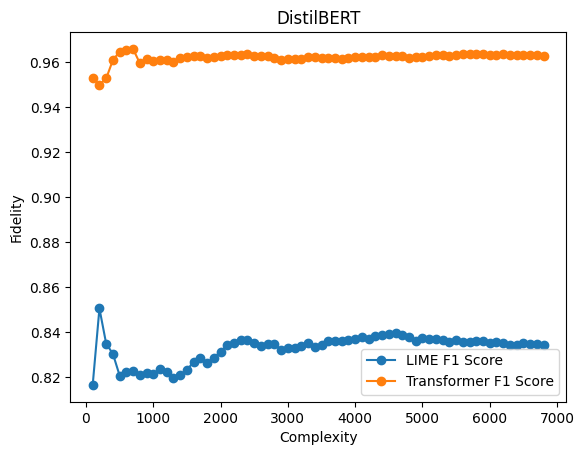

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Initialize the lists to store the F1 scores
f1_scores_lime = []
f1_scores_transformer = []

# Loop through the range of sample sizes
for size in range(100, 6810, 100):
    # Calculate the F1 scores for both models
    f1_score_lime = f1_score(true_labels[:size], lime_labels[:size], average='weighted')
    f1_score_transformer = f1_score(true_labels[:size], y_pred_transformer[:size], average='weighted')

    # Append the F1 scores to the respective lists
    f1_scores_lime.append(f1_score_lime)
    f1_scores_transformer.append(f1_score_transformer)

# Plot the F1 scores for both models
plt.figure()
plt.plot(range(100, 6810, 100), f1_scores_lime, label='LIME F1 Score', marker='o')
plt.plot(range(100, 6810, 100), f1_scores_transformer, label='Transformer F1 Score', marker='o')
plt.xlabel('Complexity')
plt.ylabel('Fidelity')
plt.title('DistilBERT')
plt.legend()
plt.savefig('F1_scores_Transformer.png')
plt.show()


In [131]:
###plot actual complexity vs fidelity

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Define a helper function to calculate F1 score for a given number of samples
#def calculate_f1_score(num_samples):
    # Create a new explainer with the specified number of samples
#    explainer = LimeTextExplainer(class_names=["negative", "positive"], kernel_width=1, verbose=False, feature_selection='auto')

    # Obtain a set of instances for evaluation
#    eval_text_data = test_dataset['text'][:1000]

#    true_labels = []
#    predicted_labels = []

        for text in eval_text_data:
        true_label = 1 if text['label'] == 'positive' else 0
        true_labels.append(true_label)

        explanation = explainer.explain_instance(text['text'], predict_function)
        explanation_list = explanation.as_list()

        sentiment_score = sum([weight for _, weight in explanation_list])

        # Convert sentiment score to class label using a threshold (e.g., 0)
        predicted_label = 1 if sentiment_score > 0 else 0
        predicted_labels.append(predicted_label)

    # Calculate F1 score
    f1 = f1_score(true_labels, predicted_labels)
    return f1

# Set up the range of samples and a list to store the F1 scores
samples_range = range(100, 10000, 100)
f1_scores = []

# Calculate F1 scores for each number of samples
for num_samples in samples_range:
    f1 = calculate_f1_score(num_samples)
    f1_scores.append(f1)

# Plot the F1 scores against the number of samples
plt.plot(samples_range, f1_scores)
plt.xlabel('Number of samples for surrogate model creation')
plt.ylabel('F1 score')
plt.title('F1 score vs. Surrogate complexity')
plt.show()


IndentationError: ignored

In [128]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
lime_labels = le.fit_transform(results_df['label'])

# Calculate the true labels for the test_dataset
true_labelss = true_labels[:10000]

# Calculate F1 scores for the transformer model and LIME surrogate
f1_transformer = f1_score(true_labels, y_pred_transformer, average='weighted')
f1_lime = f1_score(true_labelss, lime_labels, average='weighted')

print("F1 score for the transformer model: ", f1_transformer)
print("F1 score for the LIME surrogate model: ", f1_lime)


ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Extract the Lime labels and y_pred labels
lime_labels = results_df['label']
y_pred_sample_lime = y_pred[:10000]

# Calculate the F1 score for Lime on the entire test set
f1_lime = f1_score(lime_labels, y_pred_sample_lime, pos_label=1) 

# Calculate the F1 score for the original DistilBERT model as a function of the number of samples
num_samples = np.arange(10, len(y_pred_sample_lime), 10)
f1_scores_distilbert = []
for n in num_samples:
    y_pred_distilbert = np.round(DistilBERT.predict(X_test[:n]))[:, 0]
    labels = y_test[:n].astype(int)
    f1 = f1_score(labels, y_pred_distilbert, pos_label=1)
    f1_scores_distilbert.append(f1)

# Calculate the F1 score as a function of the number of samples for Lime
f1_scores_lime = []
for n in num_samples:
    f1 = f1_score(lime_labels[:n], y_pred_sample_lime[:n], pos_label=1)
    f1_scores_lime.append(f1)

# Plot the F1 score as a function of the number of samples
fig, ax = plt.subplots()
ax.plot(num_samples, f1_scores_lime, 'o-', label='Lime')
ax.plot(num_samples, f1_scores_distilbert, 'o-', label='DistilBERT')
ax.set_xlabel('Number of samples\n(subcaption for complexity)', fontsize=12)
ax.set_ylabel('F1 score\n(subcaption for fidelity)', fontsize=12)
ax.set_title('F1 score for Lime and DistilBERT', fontsize=14)
ax.legend()
plt.savefig('f1_score_lime_distilbert.png')
plt.show()


In [111]:
## incorporated original model and surrogate
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Calculate F1 score for the original model
def calculate_original_model_f1_score():
    eval_text_data = test_dataset['text'][:1000]

    true_labels = []
    predicted_labels = []

    for text in eval_text_data:
        true_label = 1 if text['label'] == 'positive' else 0
        true_labels.append(true_label)

        predicted_probs = predict_function([text['text']])
        predicted_label = np.argmax(predicted_probs)
        predicted_labels.append(predicted_label)

    f1 = f1_score(true_labels, predicted_labels)
    return f1

# Calculate the F1 score for the original model
original_model_f1_score = calculate_original_model_f1_score()

# Calculate F1 scores for LIME surrogate models
samples_range = range(10, 310, 10)
f1_scores = []

for num_samples in samples_range:
    f1 = calculate_f1_score(num_samples)
    f1_scores.append(f1)

# Plot the F1 scores against the number of samples
plt.plot(samples_range, f1_scores, label='LIME surrogate models')
plt.axhline(y=original_model_f1_score, color='r', linestyle='--', label='Original model')
plt.xlabel('Number of samples for surrogate model creation')
plt.ylabel('F1 score')
plt.title('F1 score vs. Surrogate complexity')
plt.legend()
plt.show()


TypeError: ignored

In [132]:
#GET WEIGHTED PERCENTAGE ON AVERAGE WORD USED FOR LABELING
from transformers import AutoTokenizer
from lime.lime_text import LimeTextExplainer
import torch
import numpy as np
import pandas as pd

explainer = LimeTextExplainer(class_names=["negative", "positive"])
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def predict_function(text_list):
    predicted_probabilities = []
    for text in text_list:
        test_encodings = tokenizer(text, truncation=True, padding=True, return_tensors='pt')
        with torch.no_grad():
            output = DistilBERT(test_encodings['input_ids'].to(DistilBERT.device), test_encodings['attention_mask'].to(DistilBERT.device))
        predicted_probabilities.append(torch.softmax(output.logits, dim=1).cpu().detach().numpy()[0])
    return np.array(predicted_probabilities)


# get text data for the first 50 reviews
text_data = test_dataset['text'][:60]

results_df = pd.DataFrame(columns=["review_index", "word_count", "positive_count", "negative_count", "label"])

for index, text in enumerate(text_data):
    explainer = LimeTextExplainer(class_names=["negative", "positive"])
    text_to_explain = text

    max_len = 200
    if len(text_to_explain) > max_len:
        text_to_explain = text_to_explain[:max_len]

    explanation = explainer.explain_instance(text_to_explain, predict_function)
    explanation_list = explanation.as_list()

    print('Explanation for index {}: {}'.format(index, explanation.as_list()))

    positive_count = 0
    negative_count = 0

    for word, weight in explanation_list:
        if weight >= 0:
            positive_count += 1
        else:
            negative_count += 1

    total_count = positive_count + negative_count
    positive_percentage = (positive_count / total_count) * 100
    negative_percentage = (negative_count / total_count) * 100

    if positive_count > negative_count:
        label = "positive"
    else:
        label = "negative"

    word_count = len(text_to_explain.split())
    new_row = {"review_index": index, "word_count": word_count,
           "positive_count": positive_count, "negative_count": negative_count,
           "label": label}
    results_df = pd.concat([results_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
print(results_df)


KeyboardInterrupt: ignored

In [135]:
results_df = pd.read_csv('SA_transformer10000.csv')

In [136]:
# Calculate the percentage of positive and negative words required for each review
results_df['positive_percentage'] = results_df['positive_count'] / results_df['word_count']
results_df['negative_percentage'] = results_df['negative_count'] / results_df['word_count']

# Calculate the weighted average of the positive and negative percentages based on the length of each review
weighted_positive_percentage = (results_df['positive_percentage'] * results_df['word_count']).sum() / results_df['word_count'].sum()
weighted_negative_percentage = (results_df['negative_percentage'] * results_df['word_count']).sum() / results_df['word_count'].sum()

print("Weighted average percentage of words used to detect positive label: {:.2f}%".format(weighted_positive_percentage * 100))
print("Weighted average percentage of words used to detect negative label: {:.2f}%".format(weighted_negative_percentage * 100))


Weighted average percentage of words used to detect positive label: 13.86%
Weighted average percentage of words used to detect negative label: 13.55%


ROC AUC curve for LIME Surrogate

In [138]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Extract the Lime labels and y_pred labels
le = LabelEncoder()
lime_labels = le.fit_transform(results_df['label'])
y_scores = np.round(predicted_probabilities[:6809, 1])

# Calculate the ROC curve and AUC for both models
fpr_lime, tpr_lime, _ = roc_curve(lime_labels, y_scores)
roc_auc_lime = auc(fpr_lime, tpr_lime)
fpr_lstm, tpr_lstm, _ = roc_curve(true_labels, predicted_probabilities[:, 1])
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Plot the ROC curve for both models
plt.figure()
lw = 2
plt.plot(fpr_lime, tpr_lime, color='darkorange',
         lw=lw, label='Lime ROC curve (AUC = %0.2f)' % roc_auc_lime)
plt.plot(fpr_lstm, tpr_lstm, color='blue',
         lw=lw, label='LSTM ROC curve (AUC = %0.2f)' % roc_auc_lstm)
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig('ROC_curve_60.png')
plt.show()


ValueError: ignored

In [ ]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Extract the Lime labels and surrogate model predictions
le = LabelEncoder()
lime_labels = le.fit_transform(results_df['label'])
surrogate_labels = np.argmax(DistilBERT(test_dataset['label'])[0].cpu().detach().numpy(), axis=1)

# Calculate the F1 score for the surrogate model on the entire test set
f1_surrogate = f1_score(lime_labels, surrogate_labels, pos_label=1)

# Calculate the F1 score as a function of the number of samples
num_samples = np.arange(60, len(lime_labels), 50)
f1_scores = []
for n in num_samples:
    f1 = f1_score(lime_labels[:n], surrogate_labels[:n], pos_label=1)
    f1_scores.append(f1)

# Plot the F1 score as a function of the number of samples
plt.plot(num_samples, f1_scores, 'o-')
plt.xlabel('Number of Samples')
plt.ylabel('F1 Score')
plt.title('F1 score for surrogate model')
plt.axhline(y=f1_surrogate, color='r', linestyle='--', label='Overall F1 Score')
plt.legend()
plt.savefig('f1_score_surrogate.png')
plt.show()

# Plot the ROC curve for both models
from sklearn.metrics import roc_curve, auc

# Extract the predicted scores for the positive class for the first 60 samples
y_scores = np.round(predicted_probabilities[:60, 1])

# Calculate the ROC curve and AUC for the surrogate model
fpr_surrogate, tpr_surrogate, _ = roc_curve(lime_labels, surrogate_labels)
roc_auc_surrogate = auc(fpr_surrogate, tpr_surrogate)

# Calculate the ROC curve and AUC for Lime
fpr_lime, tpr_lime, _ = roc_curve(lime_labels, y_scores)
roc_auc_lime = auc(fpr_lime, tpr_lime)

# Plot the ROC curve for both models
plt.figure()
lw = 2
plt.plot(fpr_lime, tpr_lime, color='darkorange',
         lw=lw, label='Lime ROC curve (AUC = %0.2f)' % roc_auc_lime)
plt.plot(fpr_surrogate, tpr_surrogate, color='blue',
         lw=lw, label='Surrogate ROC curve (AUC = %0.2f)' % roc_auc_surrogate)
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig('ROC_curve_surrogate.png')
plt.show()


In [ ]:
# loop over batches
num_features = 5
batch_size = 3
num_reviews = 3

results_df = pd.DataFrame(columns=["review_index", "word_count", "positive_count", "negative_count", "label"])

for i in range(math.ceil(num_reviews/batch_size)):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, num_reviews)
    batch_texts = text_data[start_idx:end_idx]
    
    for idx, batch_text in enumerate(batch_texts):
        explainer = LimeTextExplainer(class_names=["negative", "positive"])
        text_to_explain = batch_text

        max_len = 200
        if len(text_to_explain) > max_len:
            text_to_explain = text_to_explain[:max_len]

        explanation = explainer.explain_instance(text_to_explain, predict_function, num_features=num_features, top_labels=2)
        
        explanation_list = explanation.as_list()
        positive_count = 0
        negative_count = 0

        for word, weight in explanation_list:
            if weight >= 0:
                positive_count += 1
            else:
                negative_count += 1

        total_count = positive_count + negative_count
        positive_percentage = (positive_count / total_count) * 100
        negative_percentage = (negative_count / total_count) * 100

        available_labels = explanation.available_labels()
        if available_labels[0] == "positive":
            label = "positive"

        word_count = len(text_to_explain.split())

        new_row = {"review_index": start_idx+idx, "word_count": word_count, 
           "positive_count": positive_count, "negative_count": negative_count,
           "label": label}
        results_df = pd.concat([results_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)


    print("Completed batch:", i+1, "out of", math.ceil(num_reviews/batch_size))


In [ ]:
#explainer for whole dataset via batch

from transformers import AutoTokenizer
from lime.lime_text import LimeTextExplainer
import torch
import math
import numpy as np
import pandas as pd

explainer = LimeTextExplainer(class_names=["negative", "positive"])
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def predict_function(text_list):
    predicted_probabilities = []
    for text in text_list:
        test_encodings = tokenizer(text, truncation=True, padding=True, return_tensors='pt')
        with torch.no_grad():
            output = DistilBERT(test_encodings['input_ids'].to(DistilBERT.device), test_encodings['attention_mask'].to(DistilBERT.device))
        predicted_probabilities.append(torch.softmax(output.logits, dim=1).cpu().detach().numpy()[0])
    return np.array(predicted_probabilities)


# get text data
text_data = test_dataset['text']

# loop over batches
num_features = 5
batch_size = 20

results_df = pd.DataFrame(columns=["review_index", "word_count", "positive_count", "negative_count", "label"])

for i in range(math.ceil(len(text_data)/batch_size)):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(text_data))
    batch_texts = text_data[start_idx:end_idx]
    
    for idx, batch_text in enumerate(batch_texts):
        explainer = LimeTextExplainer(class_names=["negative", "positive"])
        text_to_explain = batch_text

        max_len = 200
        if len(text_to_explain) > max_len:
            text_to_explain = text_to_explain[:max_len]

        explanation = explainer.explain_instance(text_to_explain, predict_function, num_features=num_features, top_labels=2)
        
        explanation_list = explanation.as_list()
        positive_count = 0
        negative_count = 0

        for word, weight in explanation_list:
            if weight >= 0:
                positive_count += 1
            else:
                negative_count += 1

        total_count = positive_count + negative_count
        positive_percentage = (positive_count / total_count) * 100
        negative_percentage = (negative_count / total_count) * 100

        available_labels = explanation.available_labels()
        if available_labels[0] == "positive":
            label = "positive"

        word_count = len(text_to_explain.split())

        new_row = {"review_index": start_idx+idx, "word_count": word_count, 
           "positive_count": positive_count, "negative_count": negative_count,
           "label": label}
        results_df = pd.concat([results_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

        results_df = results_df.append({"review_index": start_idx+idx,
                                         "word_count": word_count,
                                         "positive_count": positive_count,
                                         "negative_count": negative_count,
                                         "label": label}, ignore_index=True)

    print("Completed batch:", i+1, "out of", math.ceil(len(text_data)/batch_size))

print(results_df)


In [ ]:
from transformers import AutoTokenizer
from lime.lime_text import LimeTextExplainer
import torch
import math
import numpy as np


index = 4
explainer = LimeTextExplainer(class_names=["negative", "positive"])
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def print_function(review, actual_sentiment, predicted_probabilities):
    print("Review: ", review)
    print("Actual sentiment: ", actual_sentiment)
    print("Predicted probabilities: ", predicted_probabilities)
    print()

def predict_function(text_list):
    predicted_probabilities = []
    for text in text_list:
        test_encodings = tokenizer(text, truncation=True, padding=True, return_tensors='pt')
        with torch.no_grad():
            output = model(test_encodings['input_ids'].to(model.device), test_encodings['attention_mask'].to(model.device))
        predicted_probabilities.append(torch.softmax(output.logits, dim=1).cpu().detach().numpy()[0])
    return np.array(predicted_probabilities)


# get text data
text_data = test_dataset['text']

# loop over batches
num_features = 5
batch_size = 8
for i in range(math.ceil(len(text_data)/batch_size)):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(text_data))
    batch_texts = text_data[start_idx:end_idx]
    exp = explainer.explain_instance('\n'.join(batch_texts), predict_function, num_features=num_features, top_labels=2)
    print(exp.as_list())


Evaluate positive review

In [ ]:
positive_index = None

for i, entry in enumerate(test_dataset):
    if entry['label'] == 1:
        positive_index = i
        break

if positive_index is not None:
    print("Index of the first positive review:", positive_index)
else:
    print("No positive reviews found in the test dataset.")

In [ ]:
from lime.lime_text import LimeTextExplainer
import numpy as np
import torch
import torch.nn.functional as F
from lime.lime_text import LimeTextExplainer

index = 12500
sample = test_dataset['text'][index]
explainer = LimeTextExplainer(class_names=["negative", "positive"])

# Define softmax function
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# Define prediction function

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict_probs(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    inputs = {name: tensor.to(device) for name, tensor in inputs.items()}
    outputs = model(**inputs)
    tensor_logits = outputs[0]
    probas = F.softmax(tensor_logits, dim=1).detach().cpu().numpy()
    return probas

# Explain instance with LIME
exp = explainer.explain_instance(sample, predict_probs, num_features=6, num_samples=300)
print("Predicted LIME label:", predicted_label_str)
print("True label:", true_label_str)
print(exp.as_list())
exp.show_in_notebook(text=True)

Evaluate negative review

In [ ]:
def label_to_str(label):
    if label == 0:
        return "negative"
    elif label == 1:
        return "positive"
    else:
        raise ValueError(f"Unknown label: {label}")

In [ ]:
from lime.lime_text import LimeTextExplainer
import numpy as np
import torch
import torch.nn.functional as F
from lime.lime_text import LimeTextExplainer

imdex = 5454
sample = test_dataset['text'][index]
explainer = LimeTextExplainer(class_names=["negative", "positive"])

# Define softmax function
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# Define prediction function

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict_probs(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    inputs = {name: tensor.to(device) for name, tensor in inputs.items()}
    outputs = model(**inputs)
    tensor_logits = outputs[0]
    probas = F.softmax(tensor_logits, dim=1).detach().cpu().numpy()
    return probas

# Explain instance with LIME
exp = explainer.explain_instance(sample, predict_probs, num_features=6, num_samples=200)
print("Predicted LIME label:", predicted_label_str)
print("True label:", true_label_str)
print(exp.as_list())
exp.show_in_notebook(text=True)

In [ ]:
true_label = test_dataset['label'][index]
true_label_str = label_to_str(true_label)

# Get the predicted probabilities from the LIME explanation
lime_probas = exp.predict_proba

# Find the predicted label based on the LIME probabilities
predicted_label = np.argmax(lime_probas)
predicted_label_str = label_to_str(predicted_label)

In [ ]:
# serach for a specific text 
search_text = "New York Buscemi"

# get corresponding index 
for i, text in enumerate(test_dataset['text']):
    if text.find(search_text) != -1:
        # print the index and text searched
        print("The index of the search text is:", i)
        print(text)

In [ ]:
sample = test_dataset['text'][12001]

In [ ]:
exp = explainer.explain_instance(sample, predict_probs, num_features=6, num_samples=200)

print(exp.as_list())
exp.show_in_notebook(text=True)

In [ ]:
from lime import submodular_pick
sp_exp = submodular_pick.SubmodularPick(explainer,
                                        test_dataset['text'][5454],
                                        #tokenized_sample[:10].values,
                                        #df[features.columns].values,
                                        predict_probs,
                                        )

## T-SNE visualization

In [ ]:
def get_embeddings(texts):
    device = model.device  
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    inputs = inputs.to(device)  

    with torch.no_grad():
        outputs = model.base_model(**inputs)

    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  
    return embeddings

all_texts_test = test_dataset['text']
test_label = test_dataset['label']

sample_size = 1000
sample_indices = np.random.choice(len(all_texts_test), size=sample_size, replace=False)
sample_texts = [all_texts_test[i] for i in sample_indices]
sample_labels = np.array([test_label[i] for i in sample_indices])

sample_embeddings = get_embeddings(sample_texts)



In [ ]:
tsne = TSNE(n_components=2, random_state=123)
embeddings_2d = tsne.fit_transform(sample_embeddings)


In [ ]:
plt.figure(figsize=(10, 10))
colors = ['red', 'blue']
label_names = ['Negative', 'Positive']

for label, color, label_name in zip([0, 1], colors, label_names):
    plt.scatter(embeddings_2d[sample_labels == label, 0], embeddings_2d[sample_labels == label, 1], c=color, label=label_name, alpha=0.5)

plt.legend()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE visualization of embeddings')
plt.savefig('tsne_transformer.png')
plt.show()
